# 4D Behavioural Vector PDM Generation

> [1] B. G. Cangan, L. Heintzman, A. Hashimoto, N. Abaid, and R. K. Williams, ‘Anticipatory Human-Robot Path Planning for Search and Rescue’, arXiv:2009.03976 [cs], Sep. 2020, Accessed: Nov. 24, 2021. [Online]. Available: http://arxiv.org/abs/2009.03976

> [2] L. Heintzman, A. Hashimoto, N. Abaid, and R. K. Williams, ‘Anticipatory Planning and Dynamic Lost Person Models for Human-Robot Search and Rescue’, in 2021 IEEE International Conference on Robotics and Automation (ICRA), May 2021, pp. 8252–8258. doi: 10.1109/ICRA48506.2021.9562070.

> [3] A. Hashimoto and N. Abaid, ‘An Agent-Based Model of Lost Person Dynamics for Enabling Wilderness Search and Rescue’, presented at the ASME 2019 Dynamic Systems and Control Conference, Nov. 2019. doi: 10.1115/DSCC2019-9222.

In [1]:
# Setup
import sys, os
from loguru import logger

sys.path.insert(0, os.path.join(os.getcwd(), "../src")) # run from within examples folder

if os.environ.get("DEBUG", "False") == "False":
    logger.remove()
    logger.add(sys.stderr, level="INFO")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from tqdm.notebook import tqdm

## Create vectors

Define behaviours

In [3]:
random_walk = np.ones(9)/9
line_following = np.array([1/3,1/3,1/3,0,0,0,0,0,0]) # if on a linear feature
straight_travel = np.array([0,1,0,0,0,0,0,0,0])
staying_put = np.array([0,0,0,0,1,0,0,0,0])

Generate all possible 4D vectors with 0.1 increments
Should be length 266 but is 258... is the paper wrong?

In [4]:

x = np.arange(0,1.1,0.1)
mesh = np.meshgrid(x,x,x,x)
vec = np.vstack([f.flatten() for f in mesh])
vec = vec[:,np.sum(vec,axis=0)==1.0]
vec[[0,1]] = vec[[1,0]] # prettier graphs
vec, vec.shape

(array([[0. , 0. , 0. , ..., 0.9, 0.9, 1. ],
        [0. , 0. , 0. , ..., 0. , 0.1, 0. ],
        [0. , 0.1, 0.2, ..., 0.1, 0. , 0. ],
        [1. , 0.9, 0.8, ..., 0. , 0. , 0. ]]),
 (4, 258))

Show all variations

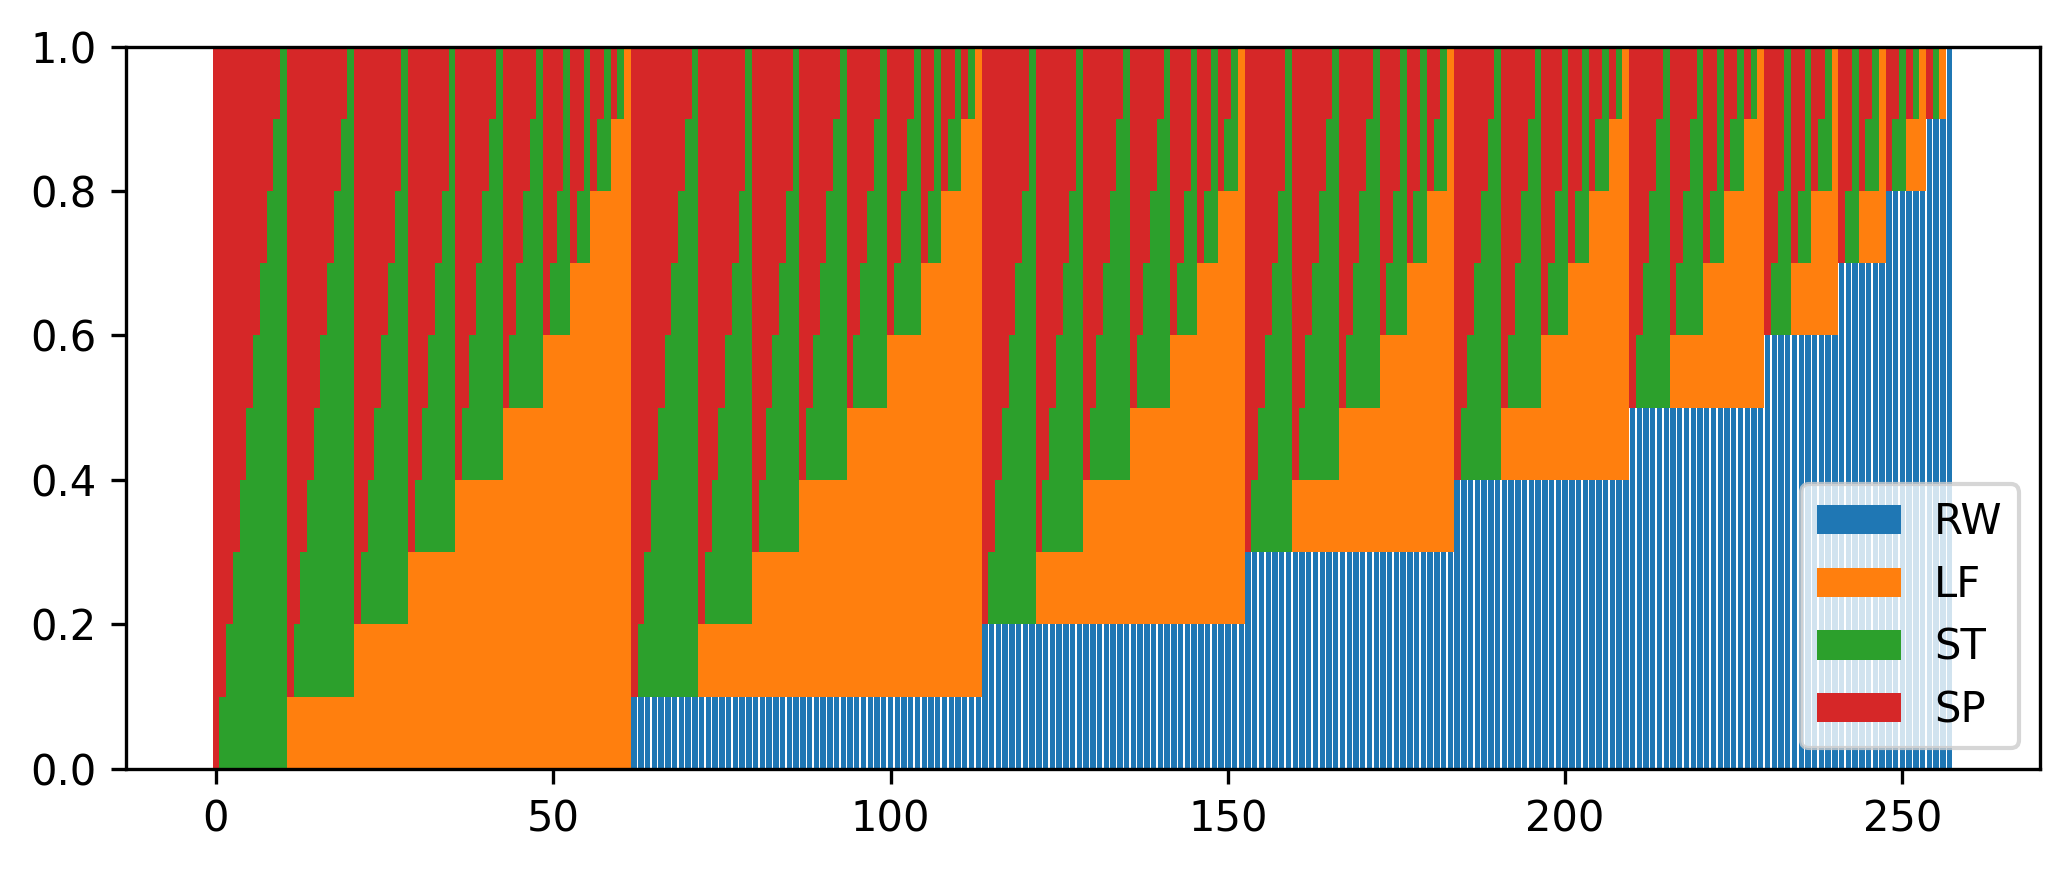

In [5]:
fig, ax = plt.subplots(figsize=(7,3), dpi=300)
x = np.arange(0,vec.shape[1])
labels = iter(['RW','LF','ST','SP'])
ax.bar(x, vec[0,:],label=next(labels))
for i in range(3):
    ax.bar(x, vec[i+1,:], width=1.0, bottom=np.sum(vec[:i+1,:],axis=0), label=next(labels))
ax.legend()
fig.tight_layout()
plt.show()

## Import GeoTIFF image with slope data

> [4]: Lidar Composite Digital Terrain Model Scotland (Phase2) 1m resolution [ASC geospatial data], Scale 1:4000, Tiles: nr82ne,nr83se,nr92nw,nr92sw,nr93sw,nr91ne,nr92ne,nr92se,nr93se,ns02ne,ns02nw,ns02se,ns02sw,ns03se,ns03sw, Updated: 1 July 2014, Non-Commercial Government Licence, Using: EDINA LIDAR Digimap Service, <https://digimap.edina.ac.uk>, Downloaded: 2022-01-28 13:08:03.643

In [6]:
import rasterio as rs
dataset_slope = rs.open('./5m_arran_b_merged_slope.tif')
dataset_dem = rs.open('./5m_arran_b_merged.tif')

slope = dataset_slope.read(1)
slope[slope == -9999.] = 0
slope = np.deg2rad(slope) # so we don't have to worry anymore

dem = dataset_dem.read(1)

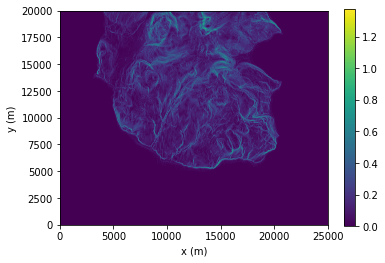

In [7]:
fig, ax = plt.subplots()
mesh = ax.imshow(slope, extent=[0,5000*5,0,4000*5])
fig.colorbar(mesh)
ax.set_ylabel("y (m)")
ax.set_xlabel("x (m)")
plt.show()

## Canny edge detection
https://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html

In [8]:
from skimage import feature

edges_rough = feature.canny(slope).astype(int)
edges = feature.canny(slope, sigma=3).astype(int)

Display results

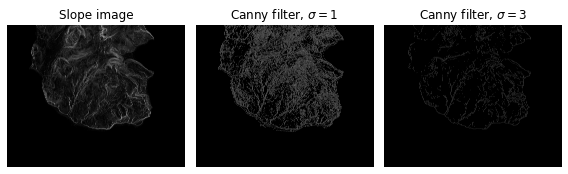

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax1.imshow(slope, cmap='gray')
ax1.set_title('Slope image')

ax2.imshow(edges_rough, cmap='gray')
ax2.set_title(r'Canny filter, $\sigma=1$')

ax3.imshow(edges, cmap='gray')
ax3.set_title(r'Canny filter, $\sigma=3$')

for a in [ax1,ax2,ax3]:
    a.axis('off')

fig.tight_layout()
plt.show()

# Implement the code

In [11]:
x0 = 3000
y0 = 2000

x_path = {}
y_path = {}

for prob_vec in tqdm(range(vec.shape[1])):
    tvec = vec[:,prob_vec]
    x = x0
    y = y0
    x_path[prob_vec] = [x]
    y_path[prob_vec] = [y]
    for i in range(500):
        strat = np.random.choice(np.arange(4), p=tvec)

        if strat == 0:
            # RW
            vx, vy = np.random.randint(-1,2, size=(2,))

        elif strat == 1:
            # LF
            vicinity = edges_rough[x-1:x+2,y-1:y+2]

            if (vicinity == 1).any():
                direction = np.random.choice(np.where(vicinity==1)[0])
                lookup = {0:(-1,1),1:(0,1),2:(1,1),3:(-1,0),4:(0,0),5:(1,0),6:(-1,-1),7:(0,-1),8:(1,-1)}
                vx, vy = lookup[direction]
            else:
                vx, vy = np.random.randint(-1,2,size=(2,))
        elif strat == 3:
            # ST
            vx = 0
            vy = 1
        else:
            # SP
            vx = 0
            vy = 0

        x += vx
        y += vy

        x_path[prob_vec].append(x)
        y_path[prob_vec].append(y)

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

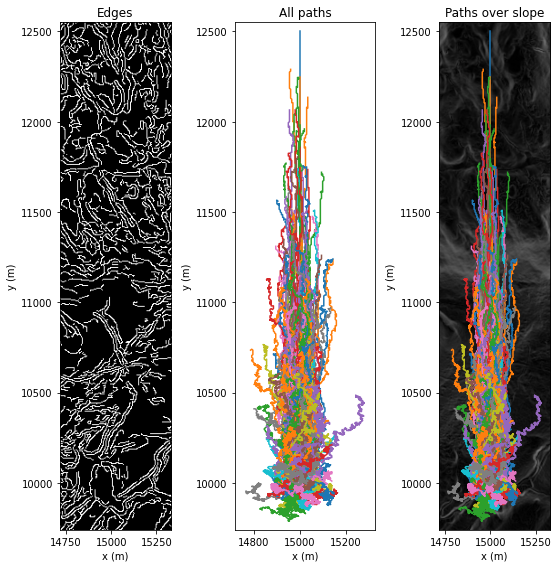

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(8,8))

ax1.imshow(edges_rough, cmap='gray', extent=[0,5000*5,0,4000*5])
ax3.imshow(slope, cmap='gray', extent=[0,5000*5,0,4000*5])

max_x, min_x = -np.inf, np.inf
max_y, min_y = -np.inf, np.inf

for i in tqdm(range(vec.shape[1])):
    x, y = np.array([x_path[i], y_path[i]])*5 # scale as each pixel is 5m
    max_x = max(max_x, np.max(x))
    min_x = min(min_x, np.min(x))
    max_y = max(max_y, np.max(y))
    min_y = min(min_y, np.min(y))
    [ax.plot(x, y) for ax in [ax2,ax3]]

for ax in [ax1,ax2,ax3]:
    ax.set_ylim([min_y-50, 50+max_y])
    ax.set_xlim([min_x-50, 50+max_x])
    ax.set_ylabel("y (m)")
    ax.set_xlabel("x (m)")

ax1.set_title("Edges")
ax2.set_title("All paths")
ax3.set_title("Paths over slope")
fig.tight_layout()
plt.show()